Ariadna Gonzalez, Júlia Dalmau i Mireia Cuenca

# INDEXING

In [1]:
#Imports

from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import time
import string
import nltk
import json
import pandas as pd 
import random

In [2]:
#Load data into memory

docs_path = 'C:/Users/mirei/Downloads/IRWA - Project-20221011/data/data/tw_hurricane_data.json' #path of tw_hurricane_data.json
with open(docs_path) as fp:
    lines = fp.readlines()
    
#Print lines[0] to see the structure of the data 

print(lines[12])

{"created_at": "Fri Sep 30 18:38:31 +0000 2022", "id": 1575918028717707265, "id_str": "1575918028717707265", "full_text": "Together we have raised over $20,000 in less than 24 hours for #HurricaneIan relief. \n\nPlease stop by the @BigManBigHeart_ tailgate tomorrow to donate in person. My family &amp; team will be at Tent #2 on the Legacy Walk near Gate K! \n\n#HurricaneRelief #NoleFam https://t.co/ikmWOP0bR0", "truncated": false, "display_text_range": [0, 261], "entities": {"hashtags": [{"text": "HurricaneIan", "indices": [63, 76]}, {"text": "HurricaneRelief", "indices": [236, 252]}, {"text": "NoleFam", "indices": [253, 261]}], "symbols": [], "user_mentions": [{"screen_name": "BigManBigHeart_", "name": "Big Man Big Heart", "id": 1428430898609938433, "id_str": "1428430898609938433", "indices": [106, 122]}], "urls": [{"url": "https://t.co/ikmWOP0bR0", "expanded_url": "https://twitter.com/gibbonsdillan/status/1575538547750162432", "display_url": "twitter.com/gibbonsdillan/\u2026", "indic

In [3]:
#Transform data into a dict to make easier the code

datos_diccionario = [json.loads(line) for line in lines]

#Now if we want to access to the screen_name of a user we colud do it like this

datos_diccionario[12]['id']

1575918028717707265

In [4]:
def build_terms(line):

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))

    #Transform in lowercase
    line=  line.lower()
    
    #Removing punctuation marks
    line= line.translate(str.maketrans('', '', string.punctuation)) 
    
    #Tokenize the text to get a list of terms
    line=  line.split(" ")
    
    #Removing the stopwords
    line=[x for x in line if x not in stop_words]
    
    #Perform stemming
    line=[stemmer.stem(x) for x in line]

    return line

In [5]:
def create_index(lines, num_documents):
    
    index = defaultdict(list)
    title_index = defaultdict(float)
    idf = defaultdict(float)
    tf = defaultdict(list)  #term frequencies of terms in documents
    df = defaultdict(int)  #document frequencies of terms in the corpus
    
    for line in lines:
    
        terms = build_terms(line['full_text'])
        
        page_id = line['id']
        title = line['id_str']

        
        # The final output must return Tweet, Username, Date, Hashtags, Likes, Retweets and Url
        args = [line["id_str"], line['user']['screen_name'], line['created_at'], line['entities']['hashtags'], line['user']['favourites_count'], line['retweet_count'], line['entities']['urls']]
        
        title_index[title]=args
        

        positions_term_in_doc = {}
        for position, term in enumerate(terms):
            try:
                # if the term is already in the dict append the position to the corresponding list
                positions_term_in_doc[term].append(position) 
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                positions_term_in_doc[term] = [position]
                
        norm = 0
        for term, posting in positions_term_in_doc.items():
            norm += len(positions_term_in_doc[term]) ** 2
        norm = math.sqrt(norm)
        
        for term, posting in positions_term_in_doc.items():
            tf[term].append(np.round(len(positions_term_in_doc[term]) / norm, 4))
            df[term] += 1
        
        for term in terms:
            index[term].append(title)
            
        for term in df:
            idf[term] = np.round(np.log(float(num_documents / df[term])), 4)
            
                    
    return index, tf, df, idf, title_index

In [6]:
index, tf, df, idf, title_index = create_index(datos_diccionario, len(lines))

In [47]:
def rank_documents(terms, docs, index, idf, tf, title_index):
    
    doc_vectors = defaultdict(lambda: [0] * len(terms))
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms) 

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):
        if term not in index:
            continue

        query_vector[termIndex] = query_terms_count[term] / query_norm * idf[term]
        # Generate doc_vectors for matching docs
        for doc_index, doc in enumerate(index[term]): 
            if doc in docs and len(tf[term])>doc_index:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term] 

    # Calculate the score of each doc 
    
    doc_scores = [[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items()]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    result_scores= [x[0] for x in doc_scores]
    
    if len(result_docs) == 0:
        print("No results found, try again")
        #query = input()
        #docs = search_tf_idf(query, index)
    return result_scores,result_docs

In [48]:
def search_tf_idf(query, index):
   
    query = build_terms(query)
    docs = []
    for term in query:
        try:
            #Term is in the index
            keys = [i for i in index.keys()]
            term_docs = [index[t] for t in keys if t==term]
            docs=term_docs[0]
            
        except:
            #Term is not in index
            pass
    docs = list(docs)
    scores_docs,ranked_docs = rank_documents(query, docs, index, idf, tf, title_index)
    return scores_docs,ranked_docs

In [49]:
#QUERIES

query = "Computer Science"
scores,docs = search_tf_idf(query, index)
top = 10


print("\n======================\nSample of {} results out of {} for the searched query:\n".format(top, len(docs)))
for d_id in docs[:top]:
    print('Tweet_id: ', title_index[d_id][0], ' Username: ', title_index[d_id][1], ' Date: ', title_index[d_id][2], ' Hashtags: ', title_index[d_id][3], ' Likes: ', title_index[d_id][4], ' Url: ', title_index[d_id][5])


Sample of 10 results out of 5 for the searched query:

Tweet_id:  1575878436207443969  Username:  WorkingatDuke  Date:  Fri Sep 30 16:01:12 +0000 2022  Hashtags:  [{'text': 'HurricaneIan', 'indices': [27, 40]}]  Likes:  3918  Url:  0
Tweet_id:  1575914809383583744  Username:  wluera  Date:  Fri Sep 30 18:25:44 +0000 2022  Hashtags:  [{'text': 'HurricaneIan', 'indices': [105, 118]}]  Likes:  7766  Url:  0
Tweet_id:  1575859051233038341  Username:  LexRich5Schools  Date:  Fri Sep 30 14:44:10 +0000 2022  Hashtags:  [{'text': 'HurricaneIan', 'indices': [52, 65]}, {'text': 'D5Reads365', 'indices': [227, 238]}, {'text': 'OurD5Story', 'indices': [239, 250]}]  Likes:  10893  Url:  0
Tweet_id:  1575900541221146625  Username:  twinmetalhen54  Date:  Fri Sep 30 17:29:02 +0000 2022  Hashtags:  [{'text': 'HurricaneIan', 'indices': [113, 126]}, {'text': 'GSM', 'indices': [128, 132]}, {'text': 'Science', 'indices': [134, 142]}, {'text': 'Truth', 'indices': [144, 150]}]  Likes:  19694  Url:  0
Tweet_

In [50]:
query = "Landfall in South Carolina"
scores, docs = search_tf_idf(query, index)
top = 10


print("\n======================\nSample of {} results out of {} for the searched query:\n".format(top, len(docs)))
for d_id in docs[:top]:
    print('Tweet_id: ', title_index[d_id][0], ' Username: ', title_index[d_id][1], ' Date: ', title_index[d_id][2], ' Hashtags: ', title_index[d_id][3], ' Likes: ', title_index[d_id][4], ' Url: ', title_index[d_id][5])


Sample of 10 results out of 255 for the searched query:

Tweet_id:  1575913904143626240  Username:  NicholeDWBZ  Date:  Fri Sep 30 18:22:08 +0000 2022  Hashtags:  [{'text': 'HurricaneIan', 'indices': [5, 18]}]  Likes:  6617  Url:  0
Tweet_id:  1575916977717141504  Username:  willy_lowry  Date:  Fri Sep 30 18:34:21 +0000 2022  Hashtags:  [{'text': 'Hurricaneian', 'indices': [0, 13]}, {'text': 'Charleston', 'indices': [59, 70]}]  Likes:  5040  Url:  1
Tweet_id:  1575914959091163136  Username:  sfdb  Date:  Fri Sep 30 18:26:19 +0000 2022  Hashtags:  [{'text': 'HurricaneIan', 'indices': [0, 13]}]  Likes:  18768  Url:  0
Tweet_id:  1575909869726605313  Username:  foxweather  Date:  Fri Sep 30 18:06:06 +0000 2022  Hashtags:  [{'text': 'HurricaneIan', 'indices': [17, 30]}, {'text': 'SCwx', 'indices': [96, 101]}]  Likes:  400  Url:  9
Tweet_id:  1575914423402766336  Username:  accuweather  Date:  Fri Sep 30 18:24:12 +0000 2022  Hashtags:  [{'text': 'HurricaneIan', 'indices': [10, 23]}]  Likes

In [51]:
query = "covid"
scores,docs = search_tf_idf(query, index)
top = 10


print("\n======================\nSample of {} results out of {} for the searched query:\n".format(top, len(docs)))
for d_id in docs[:top]:
    print('Tweet_id: ', title_index[d_id][0], ' Username: ', title_index[d_id][1], ' Date: ', title_index[d_id][2], ' Hashtags: ', title_index[d_id][3], ' Likes: ', title_index[d_id][4], ' Url: ', title_index[d_id][5])


Sample of 10 results out of 4 for the searched query:

Tweet_id:  1575871626540818432  Username:  AMDPU22  Date:  Fri Sep 30 15:34:08 +0000 2022  Hashtags:  [{'text': 'MentalHealth', 'indices': [0, 13]}, {'text': 'COVID', 'indices': [55, 61]}, {'text': 'HurricaneIan', 'indices': [66, 79]}, {'text': 'DePaulSMN', 'indices': [151, 161]}]  Likes:  27  Url:  0
Tweet_id:  1575886977764728838  Username:  RamblingMyMind  Date:  Fri Sep 30 16:35:08 +0000 2022  Hashtags:  [{'text': 'COVID', 'indices': [92, 98]}, {'text': 'hurricaneian', 'indices': [131, 144]}, {'text': 'Hurricane', 'indices': [145, 155]}, {'text': 'JustBecauseYouCantSeeIt', 'indices': [156, 180]}]  Likes:  38047  Url:  1
Tweet_id:  1575865182944894978  Username:  FraserFaithful  Date:  Fri Sep 30 15:08:32 +0000 2022  Hashtags:  [{'text': 'JunkScience', 'indices': [0, 12]}, {'text': 'GlobalWarming', 'indices': [38, 52]}, {'text': 'HurricaneIan', 'indices': [71, 84]}, {'text': 'Covid', 'indices': [132, 138]}, {'text': 'FakeNews',

In [52]:
query = "instagram"
scores,docs = search_tf_idf(query, index)
top = 10


print("\n======================\nSample of {} results out of {} for the searched query:\n".format(top, len(docs)))
for d_id in docs[:top]:
    print('Tweet_id: ', title_index[d_id][0], ' Username: ', title_index[d_id][1], ' Date: ', title_index[d_id][2], ' Hashtags: ', title_index[d_id][3], ' Likes: ', title_index[d_id][4], ' Url: ', title_index[d_id][5])


Sample of 10 results out of 3 for the searched query:

Tweet_id:  1575887728964534273  Username:  pettigrewmed  Date:  Fri Sep 30 16:38:07 +0000 2022  Hashtags:  [{'text': 'hurricaneian', 'indices': [22, 35]}]  Likes:  31  Url:  0
Tweet_id:  1575859537738838016  Username:  craigtimes  Date:  Fri Sep 30 14:46:06 +0000 2022  Hashtags:  [{'text': 'Florida', 'indices': [0, 8]}, {'text': 'HurricaneIan', 'indices': [112, 125]}]  Likes:  230080  Url:  11
Tweet_id:  1575864352837701635  Username:  savcandy  Date:  Fri Sep 30 15:05:14 +0000 2022  Hashtags:  [{'text': 'savannahcandykitchen', 'indices': [238, 259]}, {'text': 'hurricaneian', 'indices': [260, 273]}]  Likes:  2288  Url:  1


In [53]:
query = "vaccine"
scores,docs = search_tf_idf(query, index)
top = 10


print("\n======================\nSample of {} results out of {} for the searched query:\n".format(top, len(docs)))
for d_id in docs[:top]:
    print('Tweet_id: ', title_index[d_id][0], ' Username: ', title_index[d_id][1], ' Date: ', title_index[d_id][2], ' Hashtags: ', title_index[d_id][3], ' Likes: ', title_index[d_id][4], ' Url: ', title_index[d_id][5])


Sample of 10 results out of 2 for the searched query:

Tweet_id:  1575905732649689089  Username:  spinning_will  Date:  Fri Sep 30 17:49:40 +0000 2022  Hashtags:  [{'text': 'HurricaneIan', 'indices': [31, 44]}, {'text': 'FJB', 'indices': [61, 65]}]  Likes:  107663  Url:  0
Tweet_id:  1575901730730283014  Username:  JTTmemes  Date:  Fri Sep 30 17:33:46 +0000 2022  Hashtags:  [{'text': 'TuaTagovailoa', 'indices': [182, 196]}, {'text': 'HurricaneIan', 'indices': [197, 210]}, {'text': 'coronavirus', 'indices': [211, 223]}, {'text': 'vaccine', 'indices': [224, 232]}]  Likes:  3664  Url:  0


# EVALUATION

In [61]:
search_results = pd.read_csv("C:/Users/mirei/Downloads/evaluation_gt.csv")
search_results.head()

,doc,query_id,label
0,doc_12,1,1
1,doc_9,1,1
2,doc_18,1,1
3,doc_45,1,1
4,doc_501,1,1


In [62]:
print_result = search_results["label"].unique()
print("The ground truth of our dataset is composed of {} Relevance Levels: {}".format(len(print_result), sorted(print_result)))

The ground truth of our dataset is composed of 2 Relevance Levels: [0, 1]


In [63]:
search_results["is_relevant"] = search_results["label"].apply(lambda y: 1 if y == 1 else 0)
search_results.head()

,doc,query_id,label,is_relevant
0,doc_12,1,1,1
1,doc_9,1,1,1
2,doc_18,1,1,1
3,doc_45,1,1,1
4,doc_501,1,1,1


In [64]:
#pasar de "doc_12" a 12
search_results["doc"]= [x.split('_')[1] for x in search_results["doc"]]

In [65]:
#pasar de doc 12- doc[12]['id']=72364724580234650
search_results["tweet_id"]= [datos_diccionario[int(x)]['id'] for x in search_results["doc"]]

search_results.head()

,doc,query_id,label,is_relevant,tweet_id
0,12,1,1,1,1575918028717707265
1,9,1,1,1,1575918057037303808
2,18,1,1,1,1575917982726860802
3,45,1,1,1,1575917411001200640
4,501,1,1,1,1575911956539912192


In [66]:
queries=["Landfall in South Carolina","Help and recovery during the hurricane disaster","Floodings in South Carolina"]


work_data = pd.DataFrame(columns = ["query_id", "tweet_id", "predicted_relevance","is_relevant"])

for i in range(len(queries)):
    rank_scores, ranked_tweets =search_tf_idf(queries[i],index)
    for j in range(len(ranked_tweets)):
        work_data = work_data.append({"query_id": i+1, "tweet_id": str(ranked_tweets[j]), "predicted_relevance": rank_scores[j]}, ignore_index=True)        
work_data.head()

,query_id,tweet_id,predicted_relevance,is_relevant
0,1,1575913904143626240,5.108402,NaN
1,1,1575916977717141504,4.835070,NaN
2,1,1575914959091163136,4.749308,NaN
3,1,1575909869726605313,4.708001,NaN
4,1,1575914423402766336,4.476474,NaN


In [67]:
#asignamos relevancia binaria a los documentos de forma aleatoria

for i in range(len(work_data)): 
    work_data['is_relevant'][i]= random.randint(0,1)
print(work_data)

    query_id             tweet_id  predicted_relevance  is_relevant
0          1  1575913904143626240             5.108402          1.0
1          1  1575916977717141504             4.835070          0.0
2          1  1575914959091163136             4.749308          1.0
3          1  1575909869726605313             4.708001          1.0
4          1  1575914423402766336             4.476474          0.0
..       ...                  ...                  ...          ...
617        3  1575860042577973248             0.722887          1.0
618        3  1575868617798787075             0.703211          1.0
619        3  1575902000318857216             0.693800          1.0
620        3  1575892527923793921             0.676263          0.0
621        3  1575866033440694272             0.645038          0.0

[622 rows x 4 columns]


<ipython-input-67-dc9bc6cc38de>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work_data['is_relevant'][i]= random.randint(0,1)


In [68]:
def precision_at_k(doc_score, y_score, k=10):
    
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k])
    relevant = sum(doc_score == 1) 
    return float(relevant) / k 

In [22]:
# Check for query 1

current_query = 1
current_query_res = work_data[work_data["query_id"] == current_query]

k = 5
print("==> Precision@{}: {}\n".format(k, precision_at_k(current_query_res["is_relevant"], current_query_res["predicted_relevance"], k)))
print("\nCheck on the dataset sorted by score:\n")
#current_query_res.sort_values("score", ascending=False).head(k)
current_query_res.sort_values("predicted_relevance", ascending=False).head(k)

==> Precision@5: 0.4


Check on the dataset sorted by score:



,query_id,tweet_id,predicted_relevance,is_relevant
0,1,1575913904143626240,5.108402,0.0
1,1,1575916977717141504,4.835070,0.0
2,1,1575914959091163136,4.749308,1.0
3,1,1575909869726605313,4.708001,0.0
4,1,1575914423402766336,4.476474,1.0


In [23]:
def recall(doc_score, y_score, k): 
  
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k])
    
    return float(relevant)/k 

In [24]:
#Asumimos que el numero total de relevantes es el numero de relevantes que hay en work_data

# Check for query 1
current_query = 1
current_query_res = work_data[work_data["query_id"] == current_query]

total_relevants= 0
for is_relevant in work_data['is_relevant']:
    if(is_relevant ==1):
        total_relevants += 1

k = total_relevants
print("==> Recall{}: {}\n".format(k, recall(current_query_res["is_relevant"], current_query_res["predicted_relevance"], k)))
print("\nCheck on the dataset sorted by score:\n")
#current_query_res.sort_values("score", ascending=False).head(k)
current_query_res.sort_values("predicted_relevance", ascending=False).head()

==> Recall298: 0.40939597315436244


Check on the dataset sorted by score:



,query_id,tweet_id,predicted_relevance,is_relevant
0,1,1575913904143626240,5.108402,0.0
1,1,1575916977717141504,4.835070,0.0
2,1,1575914959091163136,4.749308,1.0
3,1,1575909869726605313,4.708001,0.0
4,1,1575914423402766336,4.476474,1.0


In [46]:
def f1_socre(recall, precision):
    f1_score = 2*(precision*recall)/(precision+recall)
    return f1_score

In [26]:
def avg_precision_at_k(doc_score, y_score, k=10): 
    
    gtp = np.sum(doc_score == 1) # Total number of gt positives
    order = np.argsort(y_score)[::-1] 
    doc_score = np.take(doc_score, order[:k])
    
    
    # If all documents are not relevant
    if gtp == 0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    
    for i in range(len(doc_score)):
        if doc_score[i] == 1: # Only add the P@k when the doc is relevant
            n_relevant_at_i += 1
            prec_at_i += n_relevant_at_i / (i + 1) # Calculate P@K
    
    return prec_at_i / gtp 

In [27]:
avg_precision_at_k(np.array(current_query_res["is_relevant"]), np.array(current_query_res["predicted_relevance"]), 10)

0.013387978142076502

In [28]:
def map_at_k(search_res, k=10):
    avp = []

    for q in search_res["query_id"].unique():
        
        # Select data for current query 
        curr_data = search_res[search_res["query_id"] == q]
        
        # Append average precision for current query
        avp.append(avg_precision_at_k(np.array(curr_data["is_relevant"]), np.array(curr_data["predicted_relevance"]), k)) 
    
    # Return mean average precision
    return np.sum(avp) / len(avp), avp

In [29]:
map_k, avp = map_at_k(work_data, 10)
map_k

0.02849483215628984

In [30]:
def rr_at_k(doc_score, y_score, k=10):

    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k])
    if np.sum(doc_score) == 0:
        return 0
    
    return 1 / (np.argmax(doc_score == 1) + 1) 

In [69]:
labels = np.array(work_data[work_data['query_id'] == 1]["is_relevant"])
scores = np.array(work_data[work_data['query_id'] == 1]["predicted_relevance"])
np.round(rr_at_k(labels, scores, 10), 4)

1.0

In [32]:
mrr = {}
for k in [3, 5, 10]:
    RRs = []
    
    for q in search_results['query_id'].unique(): 
        
        labels = np.array(work_data[work_data['query_id'] == q]["is_relevant"])
        scores = np.array(work_data[work_data['query_id'] == q]["predicted_relevance"])
        RRs.append(rr_at_k(labels, scores, k))
        
    mrr[k] = np.round(float(sum(RRs) / len(RRs)), 4)

In [33]:
mrr

{3: 0.7778, 5: 0.7778, 10: 0.7778}

In [34]:
def dcg_at_k(doc_score, y_score, k=10):
    
    order = np.argsort(y_score)[::-1] 
    doc_score = np.take(doc_score, order[:k])
    gain = 2 ** doc_score - 1 
    discounts = np.log2(np.arange(len(doc_score)) + 2)
    
    return np.sum(gain / discounts) 

def ndcg_at_k(doc_score, y_score, k=10):
    
    dcg_max = dcg_at_k(doc_score, doc_score, k) #ideal dcg
    
    if not dcg_max:
        return 0
    
    return np.round(dcg_at_k(doc_score, y_score, k) / dcg_max, 4)

In [35]:
query_id = 1
k = 10
labels = np.array(work_data[work_data['query_id'] == query_id]["is_relevant"])
scores = np.array(work_data[work_data['query_id'] == query_id]["predicted_relevance"])
ndcg_k = np.round(ndcg_at_k(labels, scores, k), 4)
print("ndcg@{} for query with query_id={}: {}".format(k, query_id, ndcg_k))

ndcg@10 for query with query_id=1: 0.3372


In [36]:
ndcgs = []
k = 10
for q in work_data['query_id'].unique():
    labels = np.array(work_data[work_data['query_id'] == q]["is_relevant"])
    scores = np.array(work_data[work_data['query_id'] == q]["predicted_relevance"]) 
    ndcgs.append(np.round(ndcg_at_k(labels, scores, k), 4))

avg_ndcg = np.round(float(sum(ndcgs) / len(ndcgs)), 4)
print("Average ndcg@{}: {}".format(k, avg_ndcg))


Average ndcg@10: 0.4382


In [37]:
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

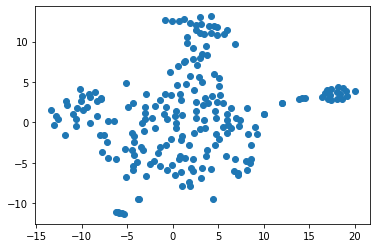

In [45]:
tweets = []
for tweet in datos_diccionario: 
    tweets.append(build_terms(tweet['full_text']))

model = Word2Vec(tweets, workers=4, min_count=50, window=10, sample=1e-3)

X = model.wv[model.wv.key_to_index]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()